# Latent Semantic Analysis of a corpus

# Setting up Python for custom modules

In [1]:
# Set up Python system path to find our modules.
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import our modules.
import file_loader as fl

# Add the file to SparkContext for the executor to find it.
sc.addPyFile('../src/file_loader.py')

# Base path for the ACL IMDB data set

In [2]:
# Load all the reviews into data frames.
base_path = "/Users/hujol/Projects/advanced_analytics_spark/data/aclImdb/"

# Process the base path into a parquet file

In [3]:
# List all the parquet files we generated.
!ls {base_path}

README                     aclImdb_250.csv
aclImdb_100000.csv         aclImdb_250_raw.parquet
aclImdb_100000_raw.parquet aclImdb_251_raw.parquet
aclImdb_10000_raw.parquet  aclImdb_252_raw.parquet
aclImdb_1000_raw.parquet   aclImdb_300_raw.parquet
aclImdb_100_raw.parquet    aclImdb_301_raw.parquet
aclImdb_20000_raw.parquet  aclImdb_50000_raw.parquet
aclImdb_2000_raw.parquet   imdb.vocab
aclImdb_200_raw.parquet    imdbEr.txt
aclImdb_210_raw.parquet    test
aclImdb_211_raw.parquet    train


In [4]:
# Total of observations
ttl_obs = 50000

# Generate a parquet file and load it into a data frame.
file_pqt, _ = fl.load_data(base_path, ttl_obs, spark)

# Load the data from the parquet file

In [5]:
# Check the parquet file is good.
df_pqt = spark.read.parquet(file_pqt)

# As needed.
# df_pqt = df_pqt.drop('words')

# Showing some observations (entries).
df_pqt.persist()
df_pqt.show(2)

+-----------+----------+----------------+--------+--------------+------------+--------------------+
|datasettype|  filename| datetimecreated|reviewid|reviewpolarity|reviewrating|                text|
+-----------+----------+----------------+--------+--------------+------------+--------------------+
|      train|9670_9.txt|20181026T065521Z|    9670|             1|           9|One of the best m...|
|      train|8747_7.txt|20181026T065521Z|    8747|             1|           7|*Possible Spoiler...|
+-----------+----------+----------------+--------+--------------+------------+--------------------+
only showing top 2 rows



In [6]:
df_pqt.count()

50000

# Pipeline Data Cleansing

## Stop Words from NLTK

In [7]:
import nltk
from nltk.corpus import stopwords

# Remove the stop words
nltk.download('stopwords')
stopwords_set = list(set(stopwords.words('english')))

stopwords_set[1:10]
# stopwords_bc = spark.sparkContext.broadcast(set(stopwords.words('english')))

[nltk_data] Downloading package stopwords to /Users/hujol/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['are', 'above', 'here', 'mustn', 'where', 'needn', 'at', 'until', 'herself']

In [8]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# Create the transformers.
html_tag_remover = fl.HTMLTagsRemover(inputCol='text', outputCol='textclean')
tokenizer = Tokenizer(inputCol="textclean", outputCol="words_tknz")
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="wordsclean", stopWords=stopwords_set)

# Create the pipeline.
pipeline_cleaner = pipeline = Pipeline(stages=[html_tag_remover, tokenizer, remover])

# Training a logistic regression for Sentiment Analysis

## Split Data Set into Training and Test Sets

In [9]:
# Split the df into train and test
df_training, df_test = df_pqt.randomSplit([0.9, 0.1], seed=12345)

df_training.count(), df_test.count()

(45043, 4957)

In [10]:
df_training.groupBy('reviewpolarity').count().show()
df_test.groupBy('reviewpolarity').count().show()

+--------------+-----+
|reviewpolarity|count|
+--------------+-----+
|             0|22625|
|             1|22418|
+--------------+-----+

+--------------+-----+
|reviewpolarity|count|
+--------------+-----+
|             0| 2375|
|             1| 2582|
+--------------+-----+



In [11]:
df_training = df_training.drop('words')
df_training = df_training.drop('featurestf')

In [12]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator , RegressionEvaluator
from pyspark.ml.feature import StopWordsRemover, HashingTF, Tokenizer, CountVectorizer, IDF
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Logistic Regression Model using N-fold Stratified Cross-Validation

In [13]:
# 1) Use this hashing Term Frequency.
hashingTF = HashingTF(inputCol=remover.getOutputCol(), outputCol="features")

# Or 2) use the Term Frequency - Inverse Document Frequency.
cv = CountVectorizer(inputCol=remover.getOutputCol(), outputCol="featurestf", vocabSize=30000, minDF=1.0)
idf = IDF(inputCol=cv.getOutputCol(), outputCol="features")

lr = LogisticRegression(maxIter=10)

# Create the pipeline.
pipeline = Pipeline(stages=[pipeline_cleaner, cv, idf, lr])

# Define the criteria ranges.
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [100, 50000, 200000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

# The evaluator of each models.
# evaluator = RegressionEvaluator(metricName="r2")
evaluator = BinaryClassificationEvaluator()

# Based on Spark doc
# https://spark.apache.org/docs/latest/ml-tuning.html#cross-validation

# Define the cross validation runner.
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
df_training_tmp = df_training.withColumnRenamed('reviewpolarity', 'label')

# Train the model.
model_cv = crossval.fit(df_training_tmp)

In [14]:
model_cv.avgMetrics

[0.9522987827953862,
 0.9438873076612284,
 0.9522039056226974,
 0.9438448853622098,
 0.9523932761131408,
 0.9438941452440787]

In [15]:
model_best = model_cv.bestModel

In [16]:
df_training_pip = model_best.transform(df_training_tmp)
eval_val = evaluator.evaluate(df_training_pip)
print(evaluator.isLargerBetter())
print(eval_val)

True
0.9984918433244083


In [17]:
df_training_pip.filter(df_training_pip.label == df_training_pip.prediction) \
    .select('label', 'probability', 'prediction', 'wordsclean').show()

+-----+--------------------+----------+--------------------+
|label|         probability|prediction|          wordsclean|
+-----+--------------------+----------+--------------------+
|    1|[0.14605655994838...|       1.0|[brilliant, over-...|
|    1|[0.13261378336360...|       1.0|[easily, underrat...|
|    1|[0.14428366775670...|       1.0|[yes, art..., suc...|
|    1|[0.22811062178718...|       1.0|["critically, acc...|
|    1|[0.22455166555926...|       1.0|[first, read, arm...|
|    1|[0.06429085264218...|       1.0|[liked, film., ac...|
|    1|[0.04828580820205...|       1.0|[enjoyed, night, ...|
|    1|[0.02213688113755...|       1.0|[night, listener,...|
|    1|[0.11145972127272...|       1.0|[popular, radio, ...|
|    1|[0.29519107207563...|       1.0|[absolutely, love...|
|    1|[0.07273930354823...|       1.0|[somewhat, funny,...|
|    1|[0.11341946777304...|       1.0|[tale, based, two...|
|    1|[0.13987202743169...|       1.0|[aro, tolbukhin, ...|
|    1|[0.17879967362450

# Evaluation of the Cross Validation Model

In [18]:
df_test_tsf = model_best.transform(df_test.withColumnRenamed('reviewpolarity', 'label'))

In [19]:
print(evaluator.evaluate(df_test_tsf))
# df_test_res.filter(df_test_res.label == df_test_res.prediction) \
#     .select('label', 'probability', 'prediction', 'features', 'words').show()

0.9566089119001963


## Confusion Matrix

In [20]:
from pyspark.mllib.evaluation import MulticlassMetrics

rdd_training_pip = df_training_pip.select('prediction', 'label').rdd.map(lambda row: (row[0], float(row[1])))
rdd_training_pip.take(2)

# print(rdd_training_pip.toDF().toPandas().shape)

metrics = MulticlassMetrics(rdd_training_pip)
print(metrics.confusionMatrix().toArray())
print()
print(metrics.truePositiveRate(1.0))
print(metrics.falsePositiveRate(1.0))

[[22196.   429.]
 [  359. 22059.]]

0.9839860826121867
0.01896132596685083


## Receiver Operating Characteristics (ROC)

In [21]:
model_cv.bestModel.stages[-1]

LogisticRegression_42d59d1f2d5dfa143aa5

In [22]:
from pyspark.ml.classification import LogisticRegressionSummary

# Get the Logistic regression model to get the summary.
summary = model_cv.bestModel.stages[-1].summary
summary.roc.show()

+---+--------------------+
|FPR|                 TPR|
+---+--------------------+
|0.0|                 0.0|
|0.0| 0.01993933446337764|
|0.0| 0.03987866892675528|
|0.0|0.059773396377910605|
|0.0| 0.07975733785351057|
|0.0| 0.09969667231688821|
|0.0| 0.11963600678026585|
|0.0|  0.1395753412436435|
|0.0|  0.1596484967436881|
|0.0| 0.17976625925595505|
|0.0| 0.19983941475599964|
|0.0|  0.2198233562315996|
|0.0| 0.23976269069497724|
|0.0|  0.2597466321705772|
|0.0|  0.2640735123561424|
|0.0| 0.28401284681952005|
|0.0| 0.30390757427067533|
|0.0| 0.32398072977071996|
|0.0|  0.3440984922829869|
|0.0| 0.36408243375858684|
+---+--------------------+
only showing top 20 rows



## Plot the ROC

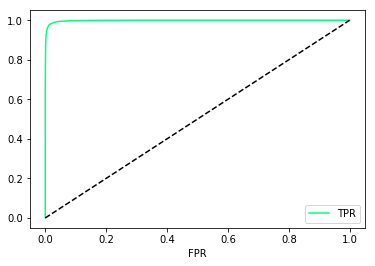

In [23]:
import matplotlib.pyplot as plt

# As defined by IPython matplotlib kernel
# https://ipython.readthedocs.io/en/stable/interactive/plotting.html#id1
%matplotlib inline

aPlt = summary.roc.toPandas().plot(x='FPR', y='TPR', colormap='winter_r')
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--', color='black')
plt.show()

# Stochastic Gradient Descent for online and out-of-core learning Using scikit-learn

## Streaming Data from a CSV File

In [24]:
!ls {base_path}/*.csv

/Users/hujol/Projects/advanced_analytics_spark/data/aclImdb//aclImdb_100000.csv
/Users/hujol/Projects/advanced_analytics_spark/data/aclImdb//aclImdb_250.csv


In [25]:
# Define the generator to stream the data from the CSV file.
def stream_doc():
    ttl = 100000 # 250
    file_csv = os.path.join(base_path, ("aclImdb_%s.csv" % ttl))

    with open(file_csv, 'r', encoding='utf-8') as csv:
        # skip header.
        next(csv)
        
        for line in csv:
            cells = line.split(',')
            filename, reviewpolarity, text = cells[1], cells[4], ",".join(cells[6:]).strip()

            yield filename, reviewpolarity, text

## Check the data

In [26]:
generator = stream_doc()
print(next(generator))
print(next(generator))

('1821_4.txt', '0', '"Alan Rickman & Emma Thompson give good performances with southern/New Orleans accents in this detective flick. It\'s worth seeing for their scenes- and Rickman\'s scene with Hal Holbrook. These three actors mannage to entertain us no matter what the movie, it seems. The plot for the movie shows potential, but one gets the impression in watching the film that it was not pulled off as well as it could have been. The fact that it is cluttered by a rather uninteresting subplot and mostly uninteresting kidnappers really muddles things. The movie is worth a view- if for nothing more than entertaining performances by Rickman, Thompson, and Holbrook."')
('9487_1.txt', '0', 'I have seen this movie and I did not care for this movie anyhow. I would not think about going to Paris because I do not like this country and its national capital. I do not like to learn french anyhow because I do not understand their language. Why would I go to France when I rather go to Germany or t

## Get Data as Mini Batches

In [27]:
# This function returns a number of documents (id, text) and their label from the doc stream.
def get_mini_batch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            filename,reviewpolarity,text = next(doc_stream)
            docs.append([filename, text])
            y.append(int(reviewpolarity))
    except StopIteration:
        return docs, y
    
    return docs, y

## Check the mini batches

In [28]:
get_mini_batch(stream_doc(), 2)

([['1821_4.txt',
   '"Alan Rickman & Emma Thompson give good performances with southern/New Orleans accents in this detective flick. It\'s worth seeing for their scenes- and Rickman\'s scene with Hal Holbrook. These three actors mannage to entertain us no matter what the movie, it seems. The plot for the movie shows potential, but one gets the impression in watching the film that it was not pulled off as well as it could have been. The fact that it is cluttered by a rather uninteresting subplot and mostly uninteresting kidnappers really muddles things. The movie is worth a view- if for nothing more than entertaining performances by Rickman, Thompson, and Holbrook."'],
  ['9487_1.txt',
   'I have seen this movie and I did not care for this movie anyhow. I would not think about going to Paris because I do not like this country and its national capital. I do not like to learn french anyhow because I do not understand their language. Why would I go to France when I rather go to Germany or 

## Set the Clean and TF Pipeline 

In [29]:
# Create a pipeline.
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression 
from pyspark.ml.evaluation import BinaryClassificationEvaluator , RegressionEvaluator
from pyspark.ml.feature import StopWordsRemover, HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# The idea is to create a features vector from a list of words.
# Use this hashing Term Frequency.
hashingTF = HashingTF(inputCol='wordsclean', outputCol="features")

# Create the pipeline.
pipeline_clean_tf = Pipeline(stages=[pipeline_cleaner, hashingTF])

# Stochastic Gradient Descent Using scikit-learn

## Generation of Mini Batch Features Vectors and Labels

In [30]:
import numpy as np

# Get the X and y labels.
def generate_X_y_labels(data_stream, size):
    data_batch, labels_batch = get_mini_batch(data_stream, size)
    
    if not data_batch: return np.empty(), np.empty()
    
    df_batch = spark.createDataFrame(data_batch, ('id', 'text'))

    # Data cleansing.
    df_training_tmp = df_batch.withColumnRenamed('reviewpolarity', 'label')

    # Run the tokenizer and remover pipeline.
    model = pipeline_clean_tf.fit(df_training_tmp)
    df_pip_batch = model.transform(df_training_tmp)

    # Let's get the right shape for the SparseVector data into numpy arrays.
    series = df_pip_batch.toPandas()['features'].apply(lambda x : np.array(x.toArray())).as_matrix().reshape(-1,1)
    X = np.apply_along_axis(lambda x : x[0], 1, series)
    y_labels =  np.array(labels_batch)

    return X, y_labels

classes = np.array([0, 1])

## Creation of the SGD Classifier

In [31]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="log", penalty="l2", max_iter=5, shuffle=True)

## Training of the SGD Model

In [41]:
# Get the streaming
data_stream = stream_doc()

# Train the 45000 data from the entire data set.
for i in range(20):
    print("Fitting batch #%i" % i)
    X_train, y_labels_train = generate_X_y_labels(data_stream, 1000)
    if not len(X_train): break
        
    # Update the SGD regression weights.
    model_sgd = clf.partial_fit(X_train, y_labels_train, classes=classes)

Fitting batch #0


/Users/hujol/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Fitting batch #1
Fitting batch #2
Fitting batch #3
Fitting batch #4
Fitting batch #5
Fitting batch #6
Fitting batch #7
Fitting batch #8
Fitting batch #9
Fitting batch #10
Fitting batch #11
Fitting batch #12
Fitting batch #13
Fitting batch #14
Fitting batch #15
Fitting batch #16
Fitting batch #17
Fitting batch #18
Fitting batch #19


## Score the Training Data Set

In [42]:
print("\nTraining Data Set Score: %.3f" % model_sgd.score(X_train, y_labels_train))


Training Data Set Score: 1.000


## Test the Model on Test Data Set

In [43]:
# Test on the last 5000 entries.
X_test, y_labels_test = generate_X_y_labels(data_stream, 5000)

print(X_test)
if len(X_test):
    print("\nTest Data Set Score: %.3f" % model_sgd.score(X_test, y_labels_test))
else:
    print('No data')

/Users/hujol/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Test Data Set Score: 0.999


In [44]:
X, Y = generate_X_y_labels(stream_doc(), 1000)
predictions = model_sgd.predict(X)
predictions[:10], Y[:10], X[:10]

/Users/hujol/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

## Predictions and Labels

In [45]:
zipped_p_l = np.dstack((predictions, Y))
predictions_and_labels = sc.parallelize(zipped_p_l[0]).map(lambda row: (float(row[0]), float(row[1])))
zipped_p_l, predictions_and_labels.take(5)

(array([[[1, 0],
         [1, 0],
         [1, 0],
         ...,
         [1, 0],
         [1, 0],
         [0, 0]]]),
 [(1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0)])

## Plot Labels and Predictions

In [66]:
Y_predictions = np.array(predictions_and_labels.toDF().toPandas()['_1'])
Y_labels = np.array(predictions_and_labels.toDF().toPandas()['_2'])

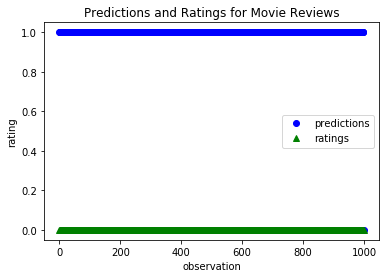

In [72]:
# Define coordinates.
Xs = np.arange(0, predictions.shape[0], 1)

plt.plot(Xs, Y_predictions, 'bo', label='predictions')
plt.plot(Xs, Y_labels, 'g^', label='ratings')

plt.xlabel('observation')
plt.ylabel('rating')

plt.title("Predictions and Ratings for Movie Reviews")

plt.legend()
plt.show()

## Metrics and Confusion Matrix

In [49]:
metrics = MulticlassMetrics(predictions_and_labels)
metrics.confusionMatrix()

DenseMatrix(1, 1, [28.0], 0)

In [54]:
print("TPR: %f" % metrics.truePositiveRate(0.0))
print("FPR: %f" % metrics.falsePositiveRate(0.0))
print("Weighted F Measure: %f" % metrics.weightedFMeasure())

TPR: 0.028000
FPR: nan
Weighted F Measure: 0.054475


# Conclusion
The SGD classifier seems to be doing too well. That means it is overfitting the training set, performs well on the test data set also but it won't generalize well.

The algo must be tuned, maybe choose another regularization, use another features vector, normalize the data, etc.

As an improvment, the plot should distinguish the observations that were properly predicted from the ones that were not.